# Setup

In [0]:
import ctypes
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, RMSprop
from keras.models import load_model

Using TensorFlow backend.


In [0]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

# Symmetric (secret-key) encryption

## Model `crypto1` (Google)

This model was build according to the specifications from Google's paper *Learning to protect communications with adversarial neural cryptography*.

In [0]:
model_name = 'crypto1'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

alice_file = './' + model_name + '-alice'
bob_file = './' + model_name + '-bob'
eve_file = './' + model_name + '-eve'

### Network arch

In [0]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('sigmoid')(aconv4)

aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')
#alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('sigmoid')(bconv4)

boutput = Flatten()(bconv4a)

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('sigmoid')(econv4)

eoutput = Flatten()(econv4a)# Eve's attempt at code guessing

eve = Model(einput, eoutput, name='eve')
#eve.summary()

In [0]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [0]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [0]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


### Train / save / restore

In [0]:
abelosses = []
boblosses = []
evelosses = []

In [0]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 20 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 7.930 | eve: 7.024 | bob: 7.894
Epoch   1:  99% | abe: 6.696 | eve: 4.147 | bob: 6.435
Epoch   2:  99% | abe: 4.945 | eve: 3.130 | bob: 4.545
Epoch   3:  99% | abe: 3.798 | eve: 2.495 | bob: 3.292
Epoch   4:  99% | abe: 2.971 | eve: 2.111 | bob: 2.398
Epoch   5:  99% | abe: 2.387 | eve: 2.005 | bob: 1.799
Epoch   6:  99% | abe: 2.032 | eve: 2.057 | bob: 1.456
Epoch   7:  99% | abe: 1.779 | eve: 2.150 | bob: 1.225
Epoch   8:  99% | abe: 1.574 | eve: 2.227 | bob: 1.038
Epoch   9:  99% | abe: 1.403 | eve: 2.290 | bob: 0.878
Epoch  10:  99% | abe: 1.267 | eve: 2.387 | bob: 0.762
Epoch  11:  99% | abe: 1.157 | eve: 2.491 | bob: 0.673
Epoch  12:  99% | abe: 1.081 | eve: 2.618 | bob: 0.615
Epoch  13:  99% | abe: 1.023 | eve: 2.728 | bob: 0.582
Epoch  14:  99% | abe: 0.985 | eve: 2.809 | bob: 0.556
Epoch  15:  99% | abe: 0.958 | eve: 2.903 | bob: 0.547
Epoch  16:  99% | abe: 0.930 | eve: 2.967 | bob: 0.528
Epoch  17:  9

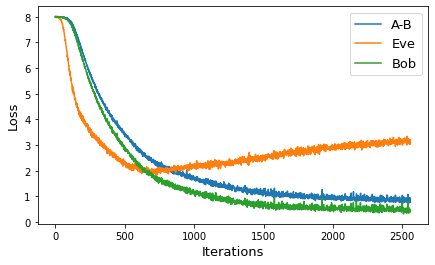

In [0]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

In [0]:
if True: #Don't overwrite by accident
    alice.save(alice_file + '.h5', overwrite=True)
    bob.save(bob_file + '.h5', overwrite=True)
    eve.save(eve_file + '.h5', overwrite=True)

In [0]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

### Evaluate

In [0]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  65.43 %
Eve % correct:  2.68 %


### Freeze Alice-Bob

In [0]:
if False:
    alice = load_model(alice_file + '.h5')
    bob = load_model(bob_file + '.h5')
    eve = load_model(eve_file + '.h5')

aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

abeoptim = RMSprop(lr=0.001)
eveoptim = Adam()#RMSprop(lr=0.001) #default 0.001

abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

abelosses = []
boblosses = []
evelosses = []

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


In [0]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        # Train Eve model only
        #
        alice.trainable = False
        m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
        k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
        eveloss = evemodel.train_on_batch([m_batch, k_batch], None)
        evelosses0.append(eveloss)
        evelosses.append(eveloss)
        eveavg = np.mean(evelosses0)
        
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        bobloss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(bobloss)
        boblosses.append(bobloss)
        bobavg = np.mean(boblosses0)
        
        # Evaluate the ABE loss
        abeloss = bobloss + ((m_bits/2 - eveloss)**2) / ( (m_bits//2)**2 )
        abelosses0.append(abeloss)
        abelosses.append(abeloss)
        abeavg = np.mean(abelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 20 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 0.871 | eve: 3.150 | bob: 0.503
Epoch   1:  99% | abe: 0.877 | eve: 3.152 | bob: 0.509
Epoch   2:  99% | abe: 0.873 | eve: 3.146 | bob: 0.505
Epoch   3:  99% | abe: 0.870 | eve: 3.147 | bob: 0.502
Epoch   4:  99% | abe: 0.874 | eve: 3.129 | bob: 0.503
Epoch   5:  99% | abe: 0.873 | eve: 3.132 | bob: 0.502
Epoch   6:  99% | abe: 0.876 | eve: 3.112 | bob: 0.503
Epoch   7:  99% | abe: 0.879 | eve: 3.140 | bob: 0.510
Epoch   8:  99% | abe: 0.876 | eve: 3.125 | bob: 0.505
Epoch   9:  99% | abe: 0.871 | eve: 3.113 | bob: 0.497
Epoch  10:  99% | abe: 0.877 | eve: 3.115 | bob: 0.504
Epoch  11:  99% | abe: 0.877 | eve: 3.105 | bob: 0.503
Epoch  12:  99% | abe: 0.874 | eve: 3.098 | bob: 0.499
Epoch  13:  99% | abe: 0.882 | eve: 3.100 | bob: 0.507
Epoch  14:  99% | abe: 0.885 | eve: 3.092 | bob: 0.508
Epoch  15:  99% | abe: 0.883 | eve: 3.093 | bob: 0.507
Epoch  16:  99% | abe: 0.880 | eve: 3.099 | bob: 0.505
Epoch  17:  9

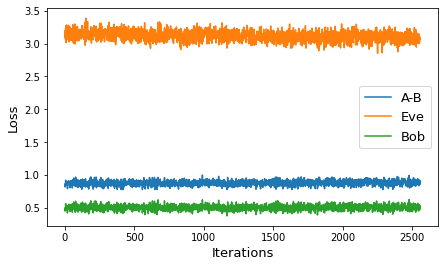

In [0]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + "-eve1.png", transparent=True) #dpi=100
plt.show()

In [0]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  64.85 %
Eve % correct:  2.88 %


### Encoding distribution

Let's plot a few of the encoded vectors' coodinates:

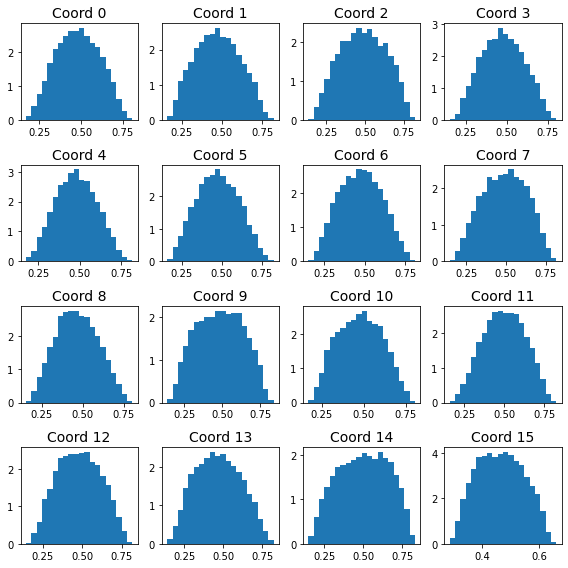

In [0]:
n_examples = 10000
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 4],
    [ 5, 6, 7, 14]
])

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
m_enc = alice.predict([m_batch, k_batch])

if showAll:
    n_cols = 4
    n_rows = m_enc.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(8, int(8.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i), fontsize=14)
            plt.hist(m_enc[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]), fontsize=12)
            plt.hist(m_enc[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
#plt.savefig("images/" + model_name + "-encall.png", transparent=True) #dpi=100
plt.show()

In [0]:
# Let's examine various correlations, if any
data_arr = np.c_[m_batch, k_batch, m_enc]

columns = [
    'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 
    'k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15', 
    'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 
]

data = pd.DataFrame(data=data_arr, index=range(10000), columns=columns)
data.head()

,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,m15,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.403227,0.242282,0.373892,0.278141,0.551807,0.496881,0.436148,0.269236,0.671533,0.388685,0.396502,0.512718,0.347338,0.658763,0.707792,0.567533
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.314502,0.393520,0.304959,0.755608,0.423116,0.301801,0.458475,0.563024,0.595298,0.475714,0.575052,0.356849,0.279250,0.257154,0.587433,0.600928
2,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.721378,0.426822,0.464860,0.535921,0.632120,0.520628,0.268349,0.616623,0.447423,0.517281,0.323931,0.461518,0.621675,0.685264,0.589057,0.413786
3,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.476933,0.450038,0.505308,0.541894,0.216270,0.530554,0.426590,0.470088,0.531909,0.646380,0.497521,0.662872,0.511360,0.514675,0.692528,0.509710
4,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.453962,0.536074,0.766344,0.428849,0.258473,0.208207,0.252995,0.734916,0.693050,0.519017,0.668580,0.348785,0.691555,0.494767,0.731273,0.443182


In [0]:
datac = data[['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15']]
datac.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,0.403227,0.242282,0.373892,0.278141,0.551807,0.496881,0.436148,0.269236,0.671533,0.388685,0.396502,0.512718,0.347338,0.658763,0.707792,0.567533
1,0.314502,0.393520,0.304959,0.755608,0.423116,0.301801,0.458475,0.563024,0.595298,0.475714,0.575052,0.356849,0.279250,0.257154,0.587433,0.600928
2,0.721378,0.426822,0.464860,0.535921,0.632120,0.520628,0.268349,0.616623,0.447423,0.517281,0.323931,0.461518,0.621675,0.685264,0.589057,0.413786
3,0.476933,0.450038,0.505308,0.541894,0.216270,0.530554,0.426590,0.470088,0.531909,0.646380,0.497521,0.662872,0.511360,0.514675,0.692528,0.509710
4,0.453962,0.536074,0.766344,0.428849,0.258473,0.208207,0.252995,0.734916,0.693050,0.519017,0.668580,0.348785,0.691555,0.494767,0.731273,0.443182


In [0]:
corr = data.corr()
corrc = datac.corr()

In [0]:
corrc['c2'].sort_values(ascending=False)

c2     1.000000
c12    0.155259
c3     0.133618
c10    0.132421
c13    0.062994
c0     0.060340
c8    -0.040202
c5    -0.049817
c11   -0.095467
c1    -0.097499
c9    -0.141009
c6    -0.173105
c4    -0.187257
c7    -0.188683
c14   -0.261277
c15   -0.333128
Name: c2, dtype: float64

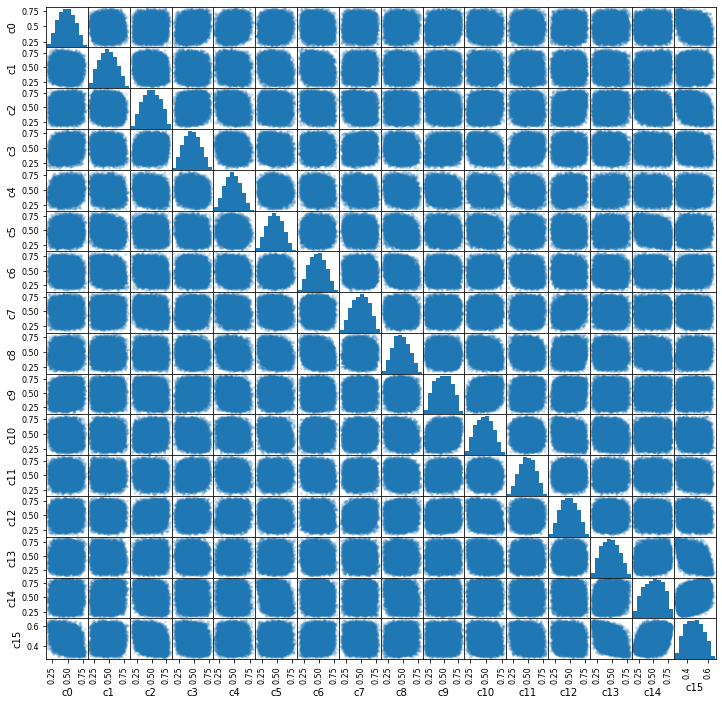

In [0]:
pd.plotting.scatter_matrix(datac, alpha=0.2, figsize=(12,12))
plt.show()

## Model `crypto2`

Add dense, and allow tanh for codings.

In [0]:
K.floatx()

'float32'

In [0]:
model_name = 'crypto2'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) # + k_bits)

alice_file = './' + model_name + '-alice'
bob_file = './' + model_name + '-bob'
eve_file = './' + model_name + '-eve'

### Network arch

In [0]:
K.clear_session()
kersize = 4

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)

areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aflat = Flatten()(aconv4a)
aoutput = Dense(units=c_bits, activation='tanh')(aflat) #ciphertext

alice = Model([ainput0, ainput1], aoutput, name='alice')
#alice.summary()


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

bflat = Flatten()(bconv4a)
boutput = Dense(units=m_bits, activation='sigmoid')(bflat) #decrypted message

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)
edense2 = Dense(units=(m_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((m_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eflat = Flatten()(econv4a)
eoutput = Dense(units=m_bits, activation='sigmoid')(eflat) #code break attempt

eve = Model(einput, eoutput, name='eve')
#eve.summary()

In [0]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [0]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss + Optimizer

In [0]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = Adam()#RMSprop(lr=0.0015)
eveoptim = Adam()#RMSprop(lr=0.0015) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


### Train / save / restore

In [0]:
# Keep track of loss at every iteration for the final graph
abelosses = []
boblosses = []
evelosses = []

In [0]:
n_epochs = 30
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = [] #epoch-bound losses for text display during training
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 30 epochs with 256 batches of size 256
Epoch   0:  99% | abe: 4.728 | eve: 4.122 | bob: 4.434
Epoch   1:  99% | abe: 2.208 | eve: 3.212 | bob: 1.834
Epoch   2:  99% | abe: 1.278 | eve: 3.889 | bob: 1.000
Epoch   3:  99% | abe: 0.809 | eve: 4.285 | bob: 0.578
Epoch   4:  99% | abe: 0.564 | eve: 4.662 | bob: 0.376
Epoch   5:  99% | abe: 0.463 | eve: 4.883 | bob: 0.298
Epoch   6:  99% | abe: 0.296 | eve: 4.919 | bob: 0.139
Epoch   7:  99% | abe: 0.221 | eve: 5.212 | bob: 0.092
Epoch   8:  99% | abe: 0.185 | eve: 5.503 | bob: 0.079
Epoch   9:  99% | abe: 0.153 | eve: 5.793 | bob: 0.067
Epoch  10:  99% | abe: 0.144 | eve: 5.827 | bob: 0.061
Epoch  11:  99% | abe: 0.125 | eve: 5.929 | bob: 0.050
Epoch  12:  99% | abe: 0.124 | eve: 5.927 | bob: 0.048
Epoch  13:  99% | abe: 0.113 | eve: 6.024 | bob: 0.043
Epoch  14:  99% | abe: 0.105 | eve: 6.024 | bob: 0.035
Epoch  15:  99% | abe: 0.097 | eve: 6.143 | bob: 0.033
Epoch  16:  99% | abe: 0.087 | eve: 6.049 | bob: 0.021
Epoch  17:  9

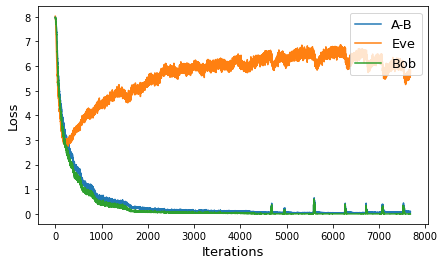

In [0]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B', alpha=0.99)
plt.plot(evelosses[:steps], label='Eve', alpha=0.99)
plt.plot(boblosses[:steps], label='Bob', alpha=0.99)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13, loc='upper right')

plt.savefig("./" + model_name + "-all.png", transparent=True, dpi=350)
plt.show()

In [0]:
alice.save(alice_file + '.h5', overwrite=True)
bob.save(bob_file + '.h5', overwrite=True)
eve.save(eve_file + '.h5', overwrite=True)

In [0]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

### Evaluate

In [0]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
#m_enc = np.round(m_enc, 3)
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  99.96 %
Eve % correct:  0.07 %


In [0]:
alice = load_model('./crypto2-alice.h5')
bob = load_model('./crypto2-bob.h5')
eve = load_model('./crypto2-eve.h5')

# Encripting images

In [0]:
!pip install bitstring

from bitstring import BitArray
from PIL import Image
import io
from matplotlib.image import imread
  
def img2bin(img_path, block_size):
  image = imread(img_path)
  hex_string = ''
  for a_byte in image.ravel():
    a_hex = str(hex(a_byte)).split('x')
    if len(a_hex[1]) < 2:
      a_hex = '0'+a_hex[1]
    else:
      a_hex = a_hex[1]
    hex_string += a_hex
    
  hexadecimal_string = hex_string
  k = 0
  img_bin_arr = []
  # print(len(hexadecimal_string), hexadecimal_string)
  
  while k<len(hexadecimal_string):
    # print(hexadecimal_string[k:k+block_size//4])
    c = BitArray(hex=hexadecimal_string[k:k+block_size//4])
    img_bin_arr.append(np.array(list(map(int,c.bin))))
    k+= 4
  return np.array(img_bin_arr)


     |████████████████████████████████| 204kB 2.7MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-cp36-none-any.whl size=37948 sha256=cd218d7a27d2fa31bec72e35aef0ac40c5c8188443480bfb82430180ecf62ba1
  Stored in directory: /root/.cache/pip/wheels/b8/27/f0/8373e26b7de57db03dc18aaaebdd8c26a99da882416f762979
Successfully built bitstring


In [0]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import urllib.request
import io
import binascii
from matplotlib.image import imsave

def bin2img(img_path, bin_img, prefix='reco_'):
  c = BitArray(bin=''.join([str(i) for i in bin_img.ravel()]))
  contents = c.hex
  original = imread(img_path)
  recovered = np.zeros((np.prod(original.shape)), dtype=np.uint8)
  # print(recovered.shape)
  k = 0
  j = 0
  # print(contents)
  while k<len(contents):
    a_hex = contents[k:k+2]
    # print(a_hex, int(a_hex, 16))
    recovered[j] = int(a_hex, 16)
    k += 2
    j += 1
    # break
  # return

  recovered = np.reshape(recovered, original.shape)
  # print(np.min(recovered))
  # print(np.max(recovered))
  # print(recovered.dtype())
  imsave(prefix + img_path, recovered )
  


In [0]:
bin_img = img2bin('img.jpg', m_bits)
bin2img('img.jpg', bin_img)

In [0]:


the_key = np.array([0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]).reshape((1,16))
the_key = np.repeat(the_key, batch_size, axis=0)

wrong_key = np.array([0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0]).reshape((1,16))
wrong_key = np.repeat(wrong_key, batch_size, axis=0)

enc_img = np.zeros(bin_img.shape)
dec_img = np.zeros(bin_img.shape, dtype=np.uint8)
wrong_img = np.zeros(bin_img.shape, dtype=np.uint8)

k = 0
while k < bin_img.shape[0] - batch_size:  
  enco = alice.predict([bin_img[k:k+batch_size], the_key])
  deco = bob.predict([enco, the_key])
  wrong = bob.predict([enco, wrong_key])
  # print(enco)
  # print(bin_img[k:k+batch_size], the_key)
  # print(np.round(deco))
  
  enc_img[k:k+batch_size] = enco
  dec_img[k:k+batch_size] = np.round(deco)
  wrong_img[k:k+batch_size] = np.round(wrong)

  k += batch_size

enco = alice.predict([bin_img[k:], the_key[:bin_img[k:].shape[0]]])
deco = bob.predict([enco, the_key[:enco.shape[0]]])
wrong = bob.predict([enco, wrong_key[:enco.shape[0]]])

enc_img[k:] = enco
dec_img[k:] = np.round(deco)
wrong_img[k:] = np.round(wrong)

In [0]:
from sklearn.preprocessing import Binarizer
transformer = Binarizer(threshold=np.mean(enc_img))
n_enc_img = transformer.fit_transform(enc_img)
enc_img = n_enc_img.astype(np.uint8)

array([-0.16316237, -0.30730551, -0.35997528,  0.13227114, -0.03844541,
        0.09998949,  0.0442577 , -0.08739813,  0.0226983 ,  0.09409296,
       -0.05438118,  0.05465247, -0.12874524,  0.02582843, -0.18844149,
        0.23855621])

In [0]:
bin2img('img.jpg', enc_img, 'encoded_')
bin2img('img.jpg', dec_img, 'decoded_')
bin2img('img.jpg', wrong_img, 'decoded_wk_')